In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import pyDOE

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        #layer definitions
        self.FC1 = nn.Linear(2,50)
        self.act1 = nn.Tanh()
        self.FC2 = nn.Linear(50,50)
        self.act2 = nn.Tanh()
        self.FC3 = nn.Linear(50,1)

    def forward(self, x, t):
        y  = torch.cat((x,t),1)
        x1 = self.FC1(y)
        x2 = self.act1(x1)
        x3 = self.FC2(x2)
        x4 = self.act2(x3)
        x5 = self.FC3(x4)
        return x5

In [3]:
"""
DE: u_x + u_t = 0
u(x,0) = e^x
"""

design = pyDOE.lhs(2, samples = 1000)
x = design[:,0] #1st variable
t = design[:,1] #2nd variable
f = np.zeros(1000) #right hand side

#boundary
x_bc = np.linspace(0,1,10)
t_bc = np.zeros(10)
u_bc = np.exp(x_bc)

#to tensor

x = x.reshape((-1, 1))
x = torch.tensor(x).type(torch.FloatTensor)
t = t.reshape((-1, 1))
t = torch.tensor(t).type(torch.FloatTensor)
f = f.reshape((-1, 1))
f = torch.tensor(f).type(torch.FloatTensor)

x_bc = x_bc.reshape((-1, 1))
x_bc = torch.tensor(x_bc).type(torch.FloatTensor)
t_bc = t_bc.reshape((-1, 1))
t_bc = torch.tensor(t_bc).type(torch.FloatTensor)
u_bc = u_bc.reshape((-1, 1))
u_bc = torch.tensor(u_bc).type(torch.FloatTensor)

In [4]:
pn = PINN()
#pn.apply(init_weights)

MAX_EPOCHS = 20000
LRATE = 1e-4

#Use Adam for training
optimizer = torch.optim.Adam(pn.parameters(), lr=LRATE)
criterion = nn.MSELoss()

loss_history_u = []
loss_history_f = []
loss_history = []

Modified Loss function:

$$L(\theta) := L_{r}(\theta) + \sum_{i=1}^{M} \lambda_{i}L_{i}(\theta)$$

$$\hat{\lambda_{i}} = \frac{\max_{\theta}|\nabla_{\theta} L_{r}(\theta)|}{\overline{|\nabla_{\theta} L_{i}(\theta)|}}$$

$$ \lambda_{i} = (1-a)\lambda_{i} + a\hat{\lambda_{i}}$$

In [5]:
l=1
for epoch in range(1000):
    #full batch

    #u
    upred_bc = pn(x_bc, t_bc)

    mse_u = criterion(input=upred_bc, target=u_bc)
    loss_history_u.append([epoch, mse_u])

    #f
    xc = x.clone()
    xc.requires_grad = True

    tc = t.clone()
    tc.requires_grad = True

    upred = pn(xc, tc)
    upred_x = torch.autograd.grad(upred.sum(),xc,create_graph=True)[0]
    upred_t = torch.autograd.grad(upred.sum(),tc,create_graph=True)[0]

    mse_f = criterion(input=upred_x + upred_t, target=f)
    loss_history_f.append([epoch, mse_f])
    
    ###custom loss
    
    if epoch%10==0:
        mse_u_grad = torch.autograd.grad(mse_u,pn.parameters(),retain_graph=True)
        mse_f_grad = torch.autograd.grad(mse_f,pn.parameters(),retain_graph=True, allow_unused=True)

        a = torch.cat([torch.flatten(i) for i in mse_u_grad])
        b = torch.cat([torch.flatten(i) for i in mse_f_grad if i is not None])

        l = 0.9*torch.max(torch.abs(b))/torch.mean(torch.abs(a)) + (1 - 0.9)*l
        
    
    
    ###
    

    

    loss = l*mse_u + mse_f
    loss_history.append([epoch, loss])

    #optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
        
    if (epoch+1) % 100 == 0:
        print("Epoch: {}, MSE_u: {:.7f}, MSE_f: {:.7f}, MSE: {:.7f}, l: {:.4f}".format((epoch+1), mse_u, mse_f, loss, l))


Epoch: 100, MSE_u: 1.7316796, MSE_f: 0.0117242, MSE: 1.9754835, l: 1.1340
Epoch: 200, MSE_u: 1.1607323, MSE_f: 0.0068449, MSE: 0.3211981, l: 0.2708
Epoch: 300, MSE_u: 0.9317682, MSE_f: 0.0083882, MSE: 0.3212498, l: 0.3358
Epoch: 400, MSE_u: 0.5649897, MSE_f: 0.0126476, MSE: 0.4373924, l: 0.7518
Epoch: 500, MSE_u: 0.1677915, MSE_f: 0.0502259, MSE: 1.6793816, l: 9.7094
Epoch: 600, MSE_u: 0.0137382, MSE_f: 1.4243178, MSE: 107.0724792, l: 7690.1104
Epoch: 700, MSE_u: 0.0064783, MSE_f: 0.7288966, MSE: 55.7517738, l: 8493.4258
Epoch: 800, MSE_u: 0.0027836, MSE_f: 0.3504493, MSE: 22.6443424, l: 8009.0166
Epoch: 900, MSE_u: 0.0010031, MSE_f: 0.1913593, MSE: 8.5393286, l: 8321.9209
Epoch: 1000, MSE_u: 0.0003984, MSE_f: 0.1498484, MSE: 0.9701295, l: 2059.1904


In [6]:
print("max gradLr :", torch.max(torch.abs(b)).item())
print("mean gradLi :", torch.mean(torch.abs(a)).item())

max gradLr : 0.3661448657512665
mean gradLi : 0.00017243331240024418


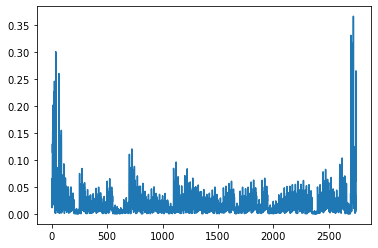

In [7]:
plt.plot(torch.abs(b))

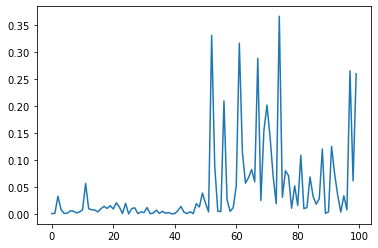

In [8]:
plt.plot(torch.abs(b[-100:]))

Big discrepancy between loss gradients wrt the network parameters, in particular the 50 last gradients 
(which correspond to last layer weights) have signifacantly larger values, which results in the loss weight blow-up.

$$  \nabla_{\theta} L_{r}(\theta)     $$
$$ L_{r}(\theta) = \frac{1}{L}\sum_{m=1}^{L}(y^{N} - y_{m})^{2}$$

$$ y^{N} = w^{TN}y^{N-1} + b^{N} $$

$$ y^{N-i} = Tanh(w^{N-i}y^{N-i-1} + b^{N-i}) \qquad i=1,\dots,N-2 $$
Loss wrt the last layer weights:
$$\frac{\partial L_{r}(\theta)}{\partial w_{i}^{N}} = \frac{1}{L}\sum_{m=1}^{L}2y^{N-1}_{i}(y^{N} - y_{m})$$

Loss wrt the second from last layer weights:
$$\frac{\partial L_{r}(\theta)}{\partial w_{ij}^{N-1}} = \frac{1}{L}\sum_{m=1}^{L}2(y^{N} - y_{m})w^{TN}[1-0.5tanh^{2}(w^{N-1}y^{N-2} + b^{N-1})]y^{N-2}_i$$
    

In [6]:
%matplotlib qt

In [7]:
X = np.linspace(0,1,100)
Y = np.linspace(0,1,100)
X, Y = np.meshgrid(X, Y)
Z=np.exp(X-Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)

In [8]:
X = np.linspace(0,1,100)
T = np.linspace(0,1,100)
X, T = np.meshgrid(X, T)


x = X.reshape((-1, 1))
x = torch.tensor(x).type(torch.FloatTensor)

t = T.reshape((-1, 1))
t = torch.tensor(t).type(torch.FloatTensor)

U = pn(x,t)

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, T,  U.detach().numpy().reshape(100,100))
ax.plot_wireframe(X, Y, Z, color = 'r')